## Behaviour if grouping and calculating the mean if NaN-values are in the group

In [1]:
import pandas as pd
import numpy as np


### Test cases to illustrate grouping on NaN values


In [2]:
# Case 1: no NaN
s1 = pd.Series([1, 2, 3])
print("Case 1 mean:", s1.mean())  # 2.0

# Case 2: some NaN
s2 = pd.Series([1, np.nan, 3])
print("Case 2 mean:", s2.mean())  # 2.0 (ignores NaN)

# Case 3: all NaN
s3 = pd.Series([np.nan, np.nan])
print("Case 3 mean:", s3.mean())  # NaN

Case 1 mean: 2.0
Case 2 mean: 2.0
Case 3 mean: nan


### Load the data and minmal adjustments

In [3]:
# Load merged hourly dataset
df = pd.read_csv("../../data_cleaned/merged/Merge_all_prices_load_gen_res.csv")
# Convert timestamp columns to datetime
df["period_start_utc"] = pd.to_datetime(df["period_start_utc"], utc=True, errors="coerce")
df["period_end_utc"] = pd.to_datetime(df["period_end_utc"], utc=True, errors="coerce")

# Optional: convert date column if needed
df["date"] = pd.to_datetime(df["date"], errors="coerce")
# Basic cleaning and sorting
# df["gen_forecast_da"] = pd.to_numeric(df["gen_forecast_da"], errors="coerce")
# df["load_forecast_da"] = pd.to_numeric(df["load_forecast_da"], errors="coerce")
df = df.sort_values("period_start_utc")

df.head(2)

,date,year,month,day,dayofyear,hour,week,dayofweek,price,period_start_utc,...,off_wind_da,off_wind_act,on_wind_da,on_wind_act,solar_da,solar_act,gen_forecast_da,gen_actual,res_sum_da,res_sum_act
0,2015-01-04,2015,1,4,4,23,1,6,22.34,2015-01-04 23:00:00+00:00,...,192.125,478.0200,11675.5250,14223.2775,0.0,0.1700,NaN,57028.5925,11867.6500,14701.4675
1,2015-01-05,2015,1,5,5,0,2,0,17.93,2015-01-05 00:00:00+00:00,...,192.375,468.5525,11924.5575,14207.5025,0.0,0.2075,NaN,56318.8525,12116.9325,14676.2625


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96336 entries, 0 to 96335
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   date              96336 non-null  datetime64[ns]     
 1   year              96336 non-null  int64              
 2   month             96336 non-null  int64              
 3   day               96336 non-null  int64              
 4   dayofyear         96336 non-null  int64              
 5   hour              96336 non-null  int64              
 6   week              96336 non-null  int64              
 7   dayofweek         96336 non-null  int64              
 8   price             96336 non-null  float64            
 9   period_start_utc  96336 non-null  datetime64[ns, UTC]
 10  period_end_utc    96336 non-null  datetime64[ns, UTC]
 11  c_by_hour         96336 non-null  int64              
 12  load_forecast_da  95229 non-null  float64            
 13  l

In [5]:
# group_cols = [
#     "date", "year", "month", "day", "dayofyear", "week", "dayofweek"
# ]

# df_d = (
#     df
#     .groupby(group_cols, as_index=False)
#     .agg(
#         price=("price", "mean"),
#         period_start_utc=("period_start_utc", "min"),
#         period_end_utc=("period_end_utc", "max"),
#         c_by_day=("year", "size"),   # count rows per group
#     )
# )
# df_d.head()

### Plot an overview on missing values

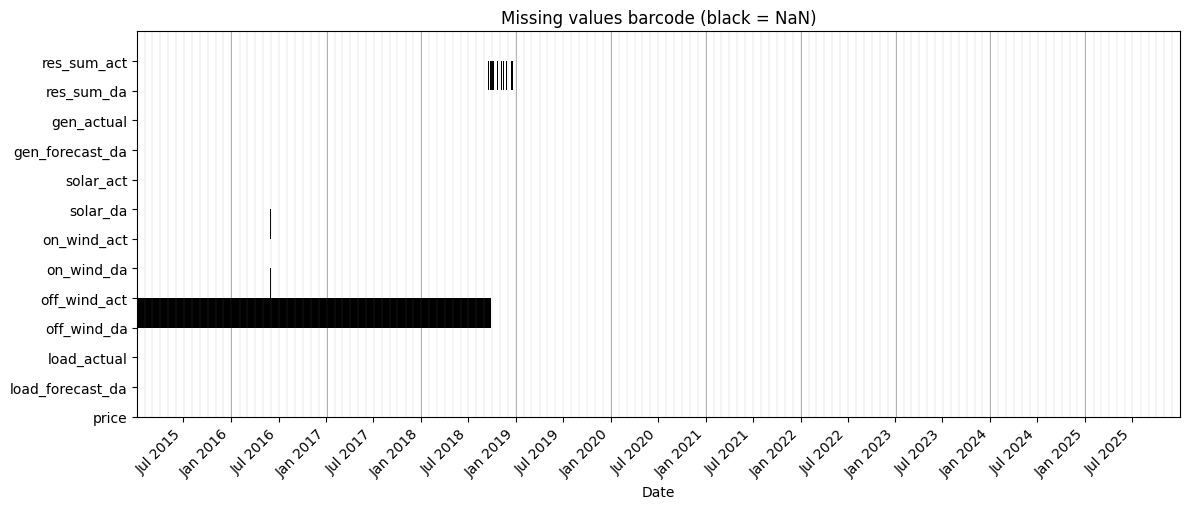

In [6]:
# Missingness "barcode" with dates on x-axis
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates

float_cols = df.select_dtypes(include="float").columns.tolist()
missing = df[float_cols].isna().values  # rows x cols

# choose x-axis values
x = pd.to_datetime(df["period_start_utc"])

fig, ax = plt.subplots(figsize=(12, 0.4 * len(float_cols)))
ax.imshow(missing.T, aspect="auto", interpolation="nearest", cmap="Greys",
          extent=[mdates.date2num(x.min()), mdates.date2num(x.max()), 0, len(float_cols)])

ax.set_yticks(range(len(float_cols)))
ax.set_yticklabels(float_cols)
ax.set_xlabel("Date")
ax.set_title("Missing values barcode (black = NaN)")

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # every 2 months
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")


# ax.xaxis_date()
# ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
# plt.setp(ax.get_xticklabels(), rotation=45, ha="right")'

# add month boundary lines
for dt in pd.date_range(x.min(), x.max(), freq="MS"):
    ax.axvline(mdates.date2num(dt), color="gray", linewidth=0.3, alpha=0.4)

# add year boundary lines
for dt in pd.date_range(x.min(), x.max(), freq="YS"):
    ax.axvline(mdates.date2num(dt), color="black", linewidth=0.5, alpha=0.4)




plt.tight_layout()
plt.show()


#### Overview on NaN-values by numerical column - first for all data, second for data from 2019 to 2025

In [7]:
nan_counts = df.select_dtypes(include="float").isna().sum()
nan_counts

price                   0
load_forecast_da     1107
load_actual             9
off_wind_da             0
off_wind_act            0
on_wind_da              3
on_wind_act            48
solar_da                3
solar_act              48
gen_forecast_da     32738
gen_actual              0
res_sum_da              0
res_sum_act             0
dtype: int64

In [8]:
df_2019_2025 = df[df["period_start_utc"].dt.year.between(2019, 2025)]
nan_counts = df_2019_2025.select_dtypes(include="float").isna().sum()
nan_counts

price                0
load_forecast_da    50
load_actual          0
off_wind_da          0
off_wind_act         0
on_wind_da           3
on_wind_act          0
solar_da             3
solar_act            0
gen_forecast_da      3
gen_actual           0
res_sum_da           0
res_sum_act          0
dtype: int64

In [9]:
nan_rows = (
    df_2019_2025.loc[:, ["period_start_utc"] + list(float_cols)]
      .melt(id_vars="period_start_utc", var_name="column", value_name="value")
)
nan_rows = nan_rows[nan_rows["value"].isna()].sort_values(["column", "period_start_utc"])
nan_rows

,period_start_utc,column,value
594589,2023-10-28 22:00:00+00:00,gen_forecast_da,NaN
603325,2024-10-26 22:00:00+00:00,gen_forecast_da,NaN
612061,2025-10-25 22:00:00+00:00,gen_forecast_da,NaN
88918,2022-02-21 23:00:00+00:00,load_forecast_da,NaN
88919,2022-02-22 00:00:00+00:00,load_forecast_da,NaN
88920,2022-02-22 01:00:00+00:00,load_forecast_da,NaN
88921,2022-02-22 02:00:00+00:00,load_forecast_da,NaN
88922,2022-02-22 03:00:00+00:00,load_forecast_da,NaN
88923,2022-02-22 04:00:00+00:00,load_forecast_da,NaN
88924,2022-02-22 05:00:00+00:00,load_forecast_da,NaN


## Conclusion for NaN-values
* in most of the cases the data is only missing in single hours -> in this case we can simply interpolate the values.
* in two cases there longer period of subsequent data is missing -> check if actual values can be used instead

### Analyse the the two periods where a longer or day period of data is missing
This is only the case for 'load_forecast_da'. One possibility is to check if the load_actual values can be taken instead without introducing a large error.
1. create a helper column calculating the difference in percent between actual and da for the load data
2. define a function plotting for given dates the actual and the da value as well as the difference between them in percent
3. plot for the two periods with longer missing values
4. conclude if the actual values can be used to impute for the longer period -> yes 

#### Create helper column

In [10]:
#df["load_diff"] =  df["load_forecast_da"] - df["load_actual"]
df["load_diff_perc"] = (df["load_forecast_da"] - df["load_actual"]) / df["load_forecast_da"].replace(0, pd.NA) * 100


#### Function to plot 

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_load_and_diff(
    df,
    start_date,
    end_date,
    feature_cols,  #=("load_forecast_da", "load_actual"),
    diff_col,      #="load_diff_perc",
    date_col="period_start_utc",
    vline_color="#555555",
    vline_alpha=0.4,
    vline_width=0.4
):
    df_plot = df.copy()
    df_plot = df_plot[df_plot[date_col].between(start_date, end_date)].copy()
    df_plot = df_plot.sort_values(date_col)

    df_hourly = df_plot[[date_col, diff_col] + list(feature_cols)]

    # fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
    fig, (ax1, ax2) = plt.subplots(
    2, 1,
    figsize=(14, 8),
    sharex=True,
    gridspec_kw={"height_ratios": [5, 2]}
)

    # Top: features
    for col in feature_cols:
        ax1.plot(
            df_hourly[date_col],
            df_hourly[col],
            alpha=0.6,
            linewidth=0.8,
            marker="o",
            markersize=2,
            label=col
        )
    ax1.set_ylabel("mega watt (MW)")
    ax1.legend(loc="upper left", ncol=2, fontsize=8)

    # Bottom: diff column
    ax2.plot(
        df_hourly[date_col],
        df_hourly[diff_col],
        color="black",
        linewidth=1.2,
        # marker="o",
        # markersize=2,
        label=diff_col
    )
    ax2.set_ylabel(diff_col)
    ax2.set_xlabel("Dates")
    ax2.legend(loc="upper left", fontsize=8)

    # Thin lines for each day
    for dt in pd.date_range(
        df_hourly[date_col].min().normalize(),
        df_hourly[date_col].max().normalize(),
        freq="D"
    ):
        ax1.axvline(dt, color=vline_color, linewidth=vline_width, alpha=vline_alpha)
        ax2.axvline(dt, color=vline_color, linewidth=vline_width, alpha=vline_alpha)

    plt.tight_layout()
    plt.show()


#### Plot the two critical moments for load

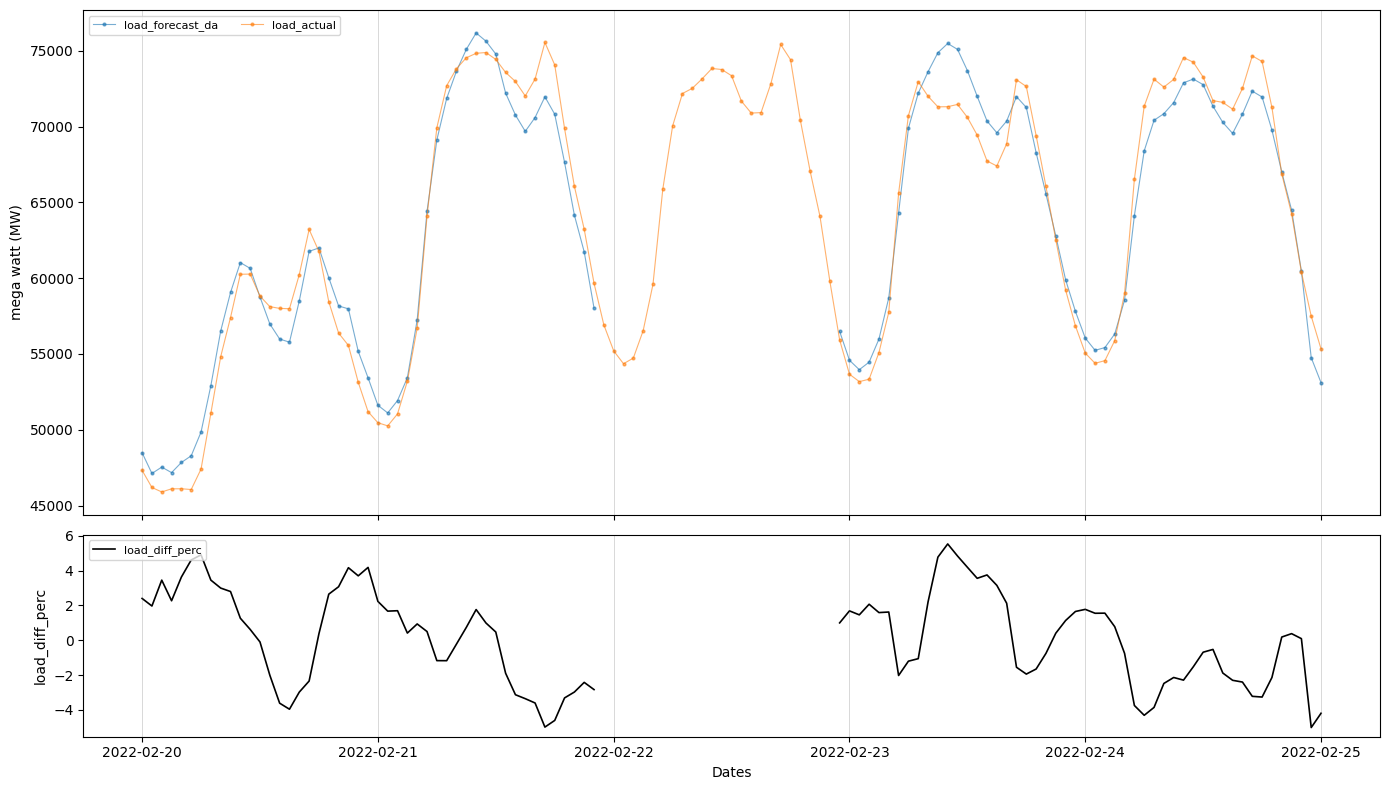

In [12]:
plot_load_and_diff(
    df, "2022-02-20", "2022-02-25",
    feature_cols=("load_forecast_da", "load_actual"),
    diff_col="load_diff_perc"
)

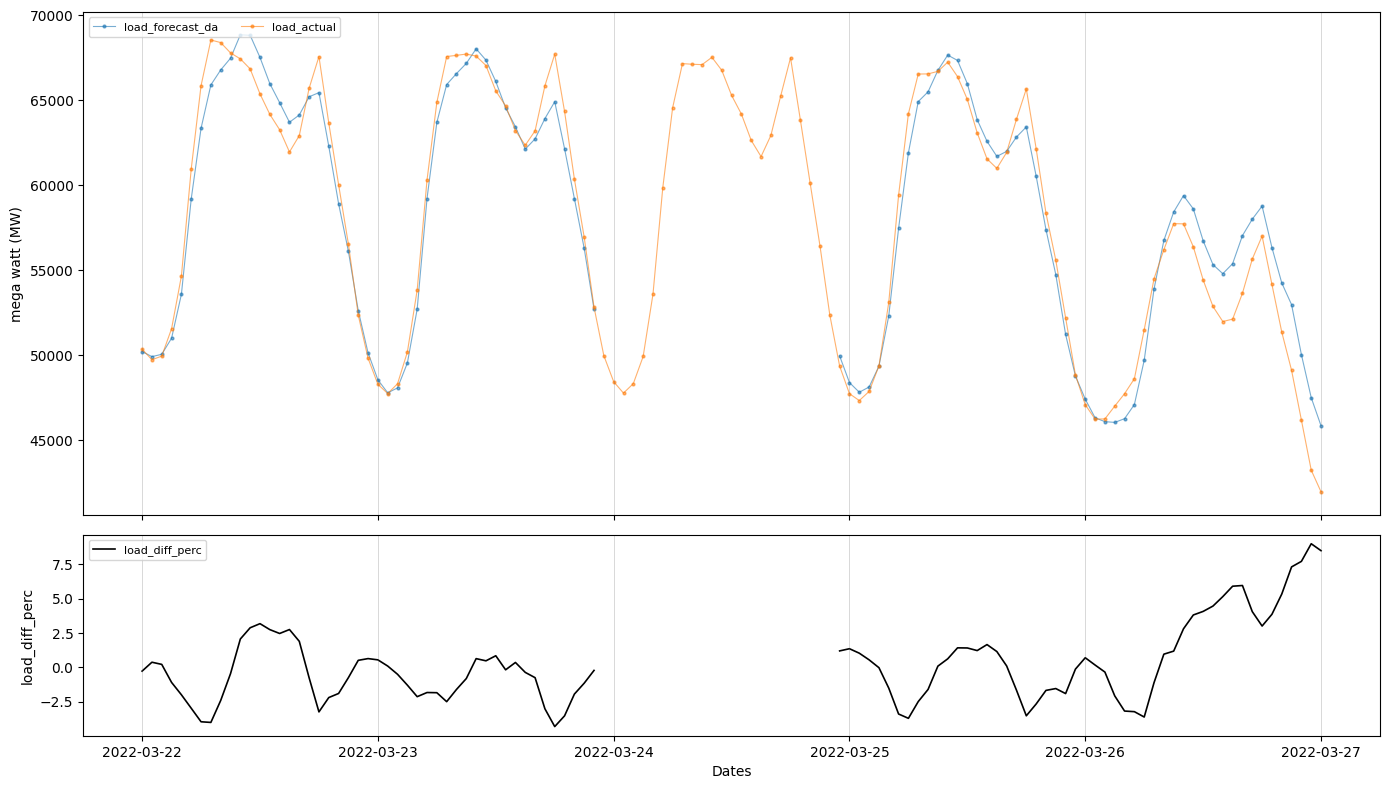

In [13]:
plot_load_and_diff(
    df, "2022-03-22", "2022-03-27",
    feature_cols=("load_forecast_da", "load_actual"),
    diff_col="load_diff_perc"
)

#### delete the helper column

In [14]:
df.drop(columns=["load_diff_perc"], inplace=True)

### Imput missing numerical values
1. use the actual load to impute for the two indicated periods
2. use simple interpolate for all other values

In [15]:
def impute_da_by_actual_data(
    df,
    target_col,
    source_col,
    start_date,
    end_date,
    date_col="period_start_utc",
):
    # mask rows in date range
    in_range = df[date_col].between(start_date, end_date)

    # rows where target is NaN and source is NOT NaN
    to_impute = in_range & df[target_col].isna() & df[source_col].notna()

    # create/overwrite imputed flag (1 if imputed, else 0)
    if "imputed" not in df.columns:
        df["imputed"] = 0
    df.loc[to_impute, "imputed"] = 1

 

    # fill target with source
    df.loc[to_impute, target_col] = df.loc[to_impute, source_col]

    return df


In [16]:
df = impute_da_by_actual_data(df, "load_forecast_da", "load_actual", "2022-02-20", "2022-02-25")

In [17]:

df = impute_da_by_actual_data(df, "load_forecast_da", "load_actual", "2022-03-22", "2022-03-27")

In [18]:
df_imputed = df[df["imputed"] == 1]
df_imputed ##['period_start_utc']


,date,year,month,day,dayofyear,hour,week,dayofweek,price,period_start_utc,...,off_wind_act,on_wind_da,on_wind_act,solar_da,solar_act,gen_forecast_da,gen_actual,res_sum_da,res_sum_act,imputed
62520,2022-02-21,2022,2,21,52,23,8,0,89.99,2022-02-21 23:00:00+00:00,...,5412.2625,33302.5475,34575.3425,0.0000,3.1125,67128.95,67411.77,39056.7800,39990.7175,1
62521,2022-02-22,2022,2,22,53,0,8,1,82.14,2022-02-22 00:00:00+00:00,...,5058.9775,32580.0700,33894.3250,0.0000,3.2300,65677.84,65781.56,37991.5100,38956.5325,1
62522,2022-02-22,2022,2,22,53,1,8,1,80.34,2022-02-22 01:00:00+00:00,...,4962.7875,32121.7300,34073.2500,0.0000,3.2225,64605.24,65521.80,37526.2675,39039.2600,1
62523,2022-02-22,2022,2,22,53,2,8,1,79.90,2022-02-22 02:00:00+00:00,...,4360.9850,31799.4250,33786.6725,0.0000,3.4025,64442.38,65814.42,37181.3700,38151.0600,1
62524,2022-02-22,2022,2,22,53,3,8,1,88.16,2022-02-22 03:00:00+00:00,...,4361.9575,31132.9775,32953.8550,0.0000,3.3175,64529.18,66145.26,36484.9000,37319.1300,1
62525,2022-02-22,2022,2,22,53,4,8,1,95.36,2022-02-22 04:00:00+00:00,...,4846.7500,30030.3400,31686.3075,0.0000,3.2875,67518.61,67302.57,35237.5100,36536.3450,1
62526,2022-02-22,2022,2,22,53,5,8,1,117.86,2022-02-22 05:00:00+00:00,...,4989.7000,28853.0075,30606.1975,0.0000,3.6275,71201.35,71649.04,33736.3300,35599.5250,1
62527,2022-02-22,2022,2,22,53,6,8,1,185.78,2022-02-22 06:00:00+00:00,...,3813.8475,26432.3650,27952.4825,486.6000,369.8625,74612.14,74021.19,31116.9600,32136.1925,1
62528,2022-02-22,2022,2,22,53,7,8,1,211.59,2022-02-22 07:00:00+00:00,...,3325.0525,23644.1025,24255.6775,3638.4425,3509.3025,75430.68,75166.85,30585.3275,31090.0325,1
62529,2022-02-22,2022,2,22,53,8,8,1,180.27,2022-02-22 08:00:00+00:00,...,2884.5425,22209.9500,22664.5375,8034.0550,8328.6550,76462.19,76754.16,33321.6300,33877.7350,1


### Run NaN statistic

In [19]:
nan_counts = df.select_dtypes(include="float").isna().sum()
nan_counts

price                   0
load_forecast_da     1059
load_actual             9
off_wind_da             0
off_wind_act            0
on_wind_da              3
on_wind_act            48
solar_da                3
solar_act              48
gen_forecast_da     32738
gen_actual              0
res_sum_da              0
res_sum_act             0
dtype: int64

In [20]:
df_2019_2025 = df[df["period_start_utc"].dt.year.between(2019, 2025)]
nan_counts = df_2019_2025.select_dtypes(include="float").isna().sum()
nan_counts

price               0
load_forecast_da    2
load_actual         0
off_wind_da         0
off_wind_act        0
on_wind_da          3
on_wind_act         0
solar_da            3
solar_act           0
gen_forecast_da     3
gen_actual          0
res_sum_da          0
res_sum_act         0
dtype: int64

### Interpolation of single missing values

In [21]:
def interpolate_limited(
    df,
    cols,
    start_date,
    end_date,
    date_col="period_start_utc",
    max_missing=1,
    method="time"
):
    """
    Interpolate only if there are <= max_missing consecutive NaNs in the range.
    Adds/updates an 'interpolated' flag where values were filled.
    """
    df = df.copy()

    if "interpolated" not in df.columns:
        df["interpolated"] = 0

    # set datetime index for time interpolation
    if method == "time":
        df = df.set_index(pd.to_datetime(df[date_col]))
        mask = df.index.to_series().between(start_date, end_date)
    else:
        mask = df[date_col].between(start_date, end_date)

    for col in cols:
        before = df.loc[mask, col].isna()

        df.loc[mask, col] = df.loc[mask, col].interpolate(
            method=method,
            limit=max_missing,
            limit_direction="both"
        )

        after = df.loc[mask, col].isna()

        # rows where NaN turned into non-NaN
        filled = before & ~after
        df.loc[mask, "interpolated"] = df.loc[mask, "interpolated"].where(~filled, 1)

    if method == "time":
        df = df.reset_index(drop=True)

    return df




In [22]:
df = interpolate_limited(
    df,
    cols=["load_forecast_da", "gen_forecast_da","on_wind_da", "solar_da"],
    start_date="2018-12-30",
    end_date="2026-02-05"
)


In [23]:
df_interp = df[df["interpolated"] == 1]
df_interp ##['period_start_utc']

,date,year,month,day,dayofyear,hour,week,dayofweek,price,period_start_utc,...,on_wind_da,on_wind_act,solar_da,solar_act,gen_forecast_da,gen_actual,res_sum_da,res_sum_act,imputed,interpolated
34944,2018-12-30,2018,12,30,364,23,52,6,50.9400,2018-12-30 23:00:00+00:00,...,8524.15250,7729.3150,0.0,0.6200,43693.92000,45956.1500,10062.4975,8699.400,0,1
77255,2023-10-28,2023,10,28,301,22,43,5,14.0500,2023-10-28 22:00:00+00:00,...,19363.62125,19922.1075,0.0,14.2950,41437.86500,40809.0500,5319.9975,25703.100,0,1
85991,2024-10-26,2024,10,26,300,22,43,5,92.2200,2024-10-26 22:00:00+00:00,...,10425.54625,13228.7900,0.0,22.9075,37629.93000,39731.1200,2661.7750,17794.600,0,1
94727,2025-10-25,2025,10,25,298,22,43,5,5.5725,2025-10-25 22:00:00+00:00,...,34893.98125,31337.4350,0.0,19.4825,56825.98875,53144.7425,5867.3050,37757.225,0,1


In [24]:
df_2019_2025 = df[df["period_start_utc"].dt.year.between(2019, 2025)]
nan_counts = df_2019_2025.select_dtypes(include="float").isna().sum()
nan_counts

price               0
load_forecast_da    0
load_actual         0
off_wind_da         0
off_wind_act        0
on_wind_da          0
on_wind_act         0
solar_da            0
solar_act           0
gen_forecast_da     0
gen_actual          0
res_sum_da          0
res_sum_act         0
dtype: int64

### Save the imputed data

In [26]:
df.to_csv("../../data_cleaned/merged/Data_imputed_2019_to_2025.csv", index=False)

### Appendix

In [25]:
float_cols = df.select_dtypes(include="float").columns

nan_per_year = (
    df_2019_2025.groupby(df["period_start_utc"].dt.year)[float_cols]
      .apply(lambda g: g.isna().sum())
)

nan_total = df[float_cols].isna().sum().rename("ALL")

# put ALL as first column
nan_table = pd.concat([nan_total, nan_per_year.T], axis=1)

nan_table.style.apply(
    lambda _: ["font-weight: bold"] + [""] * (nan_table.shape[1] - 1),
    axis=1
)



,ALL,2019,2020,2021,2022,2023,2024,2025
price,0,0,0,0,0,0,0,0
load_forecast_da,1056,0,0,0,0,0,0,0
load_actual,9,0,0,0,0,0,0,0
off_wind_da,0,0,0,0,0,0,0,0
off_wind_act,0,0,0,0,0,0,0,0
on_wind_da,0,0,0,0,0,0,0,0
on_wind_act,48,0,0,0,0,0,0,0
solar_da,0,0,0,0,0,0,0,0
solar_act,48,0,0,0,0,0,0,0
gen_forecast_da,32735,0,0,0,0,0,0,0
